In [ ]:
import time
import threading
import psutil
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from datetime import datetime, timedelta
import os
import sys
from pathlib import Path
import random

# Add the parent directory to sys.path to import Config and RansomwareDetector
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(''), 'src')))
from config import Config
from ransomware_detector import RansomwareDetector, FeatureExtractor

print("Libraries imported and Config/RansomwareDetector loaded.")

# Ensure monitoring paths exist for simulation
for path in Config.FILE_MONITOR_PATHS:
    Path(path).mkdir(parents=True, exist_ok=True)
    print(f"Ensured monitoring directory exists: {path}")

# Initialize the detector (without starting its internal monitoring yet)
detector = RansomwareDetector()
feature_extractor = FeatureExtractor()


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
2025-10-01 14:59:41,675 - INFO - Attempting to create/train default model...
2025-10-01 14:59:41,675 - INFO - Loading training data from D:\ransomware-detection-system\src\test_data\training_dataset.csv...
2025-10-01 14:59:41,831 - INFO - Training model with 100000 samples...


Libraries imported and Config/RansomwareDetector loaded.
Ensured monitoring directory exists: D:\testing123


2025-10-01 14:59:43,165 - INFO - Model saved to D:\ransomware-detection-system\models\ransomware_model.joblib
2025-10-01 14:59:43,165 - INFO - Feature scaler saved to D:\ransomware-detection-system\models\feature_scaler.joblib
2025-10-01 14:59:43,166 - INFO - Model training completed successfully.


# Ransomware Detection System Performance Evaluation

This notebook is dedicated to evaluating the operational performance of the Ransomware Detection System, focusing on key metrics such as CPU usage, memory consumption, and detection latency. These metrics are critical for understanding the system's efficiency and responsiveness in a real-world deployment scenario.

We will:
1.  Start the Ransomware Detector.
2.  Monitor its CPU and memory usage over a period.
3.  Simulate a ransomware event and measure the time taken for detection (latency).
4.  Visualize the collected performance data.



In [2]:
## Start the Ransomware Detector


# Global variables to control the detector's thread
detector_running = False
detector_observer = None
detector_thread = None

def run_detector():
    global detector_running, detector_observer
    detector_running = True
    print("Initializing and starting RansomwareDetector...")
    detector_observer = detector.start_monitoring()
    print("RansomwareDetector started in background.")
    while detector_running:
        time.sleep(1) # Keep the thread alive

def start_detector_thread():
    global detector_thread, detector_running
    if detector_thread is None or not detector_thread.is_alive():
        detector_thread = threading.Thread(target=run_detector, daemon=True)
        detector_thread.start()
        # Give some time for the detector to initialize
        time.sleep(Config.MONITORING_INTERVAL + 5) # Give more time for initialization with new interval
        print("Detector thread initiated.")
    else:
        print("Detector is already running.")

def stop_detector_thread():
    global detector_running, detector_observer, detector_thread
    if detector_running:
        print("Stopping RansomwareDetector...")
        detector_running = False
        detector.process_monitor.stop_monitoring()
        if detector_observer:
            detector_observer.stop()
            detector_observer.join()
        if detector_thread:
            detector_thread.join(timeout=5) # Wait for thread to finish
        print("RansomwareDetector stopped.")
        detector_thread = None
    else:
        print("Detector is not running.")

# Start the detector
start_detector_thread()


2025-10-01 14:59:48,729 - INFO - Starting ransomware detection system...
2025-10-01 14:59:48,807 - INFO - Ransomware detection system started


Initializing and starting RansomwareDetector...
RansomwareDetector started in background.
Detector thread initiated.


2025-10-01 15:03:02,231 - WARNING - ALERT [MEDIUM]: High ransomware risk detected (score: 0.71)
2025-10-01 15:03:23,415 - WARNING - ALERT [MEDIUM]: High ransomware risk detected (score: 0.74)
2025-10-01 15:03:44,455 - WARNING - ALERT [MEDIUM]: High ransomware risk detected (score: 0.71)
2025-10-01 15:04:05,785 - WARNING - ALERT [MEDIUM]: High ransomware risk detected (score: 0.71)
2025-10-01 15:04:26,836 - WARNING - ALERT [MEDIUM]: High ransomware risk detected (score: 0.71)
2025-10-01 15:04:47,873 - WARNING - ALERT [MEDIUM]: High ransomware risk detected (score: 0.71)


## Monitoring Resource Consumption (CPU & Memory)

We will monitor the CPU and memory usage of the Python process running the `RansomwareDetector` over a specified period. This helps assess the system's operational overhead.



Monitoring CPU and memory for 60 seconds...
Monitoring complete.


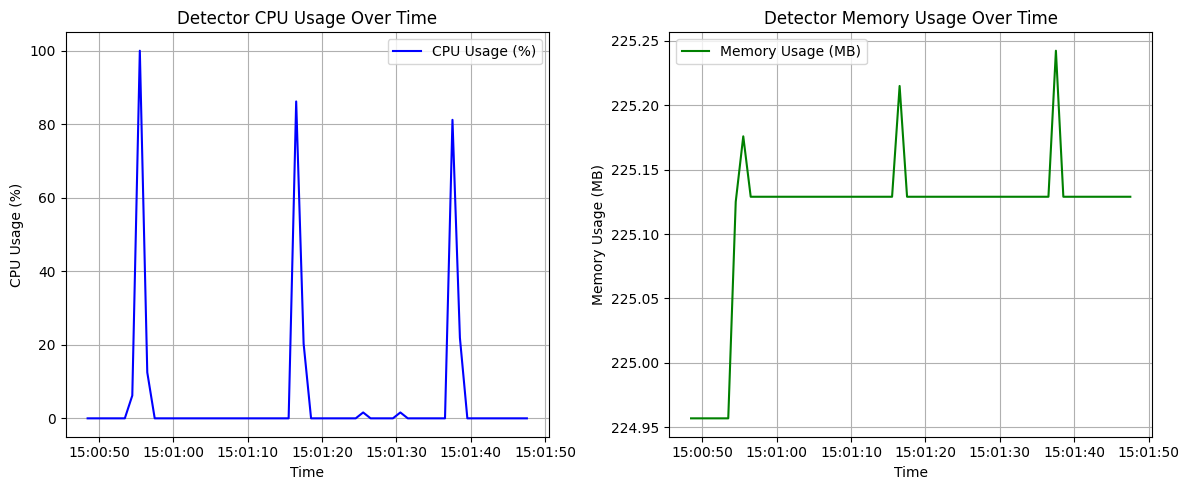


Average CPU Usage: 5.53%
Max CPU Usage: 100.00%
Average Memory Usage: 225.12 MB
Max Memory Usage: 225.24 MB


In [3]:
cpu_usages = []
memory_usages = []
timestamps = []

def monitor_resources(duration_seconds=60, interval_seconds=1):
    print(f"Monitoring CPU and memory for {duration_seconds} seconds...")
    process = psutil.Process(os.getpid())
    start_time = time.time()

    while (time.time() - start_time) < duration_seconds:
        cpu_usages.append(process.cpu_percent(interval=None)) # non-blocking
        memory_usages.append(process.memory_info().rss / (1024 * 1024)) # in MB
        timestamps.append(datetime.now())
        time.sleep(interval_seconds)

    print("Monitoring complete.")

# Run resource monitoring (e.g., for 60 seconds)
monitor_resources(duration_seconds=60)

# Plotting resource usage
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(timestamps, cpu_usages, label='CPU Usage (%)', color='blue')
plt.xlabel('Time')
plt.ylabel('CPU Usage (%)')
plt.title('Detector CPU Usage Over Time')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(timestamps, memory_usages, label='Memory Usage (MB)', color='green')
plt.xlabel('Time')
plt.ylabel('Memory Usage (MB)')
plt.title('Detector Memory Usage Over Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nAverage CPU Usage: {np.mean(cpu_usages):.2f}%")
print(f"Max CPU Usage: {np.max(cpu_usages):.2f}%")
print(f"Average Memory Usage: {np.mean(memory_usages):.2f} MB")
print(f"Max Memory Usage: {np.max(memory_usages):.2f} MB")



## Measuring Detection Latency

Detection latency is the time taken from a malicious event occurring to the system generating an alert or detection. We will simulate a ransomware-like file operation and measure this delay.



2025-10-01 15:02:04,691 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension


2025-10-01 15:02:04,735 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:02:04,780 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:02:04,795 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:02:04,845 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:02:04,849 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:04,864 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:04,870 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension


Starting 5 ransomware simulation(s) in D:\testing123...

--- Simulation 1/5 ---
  Simulating creation of 10 suspicious files...


2025-10-01 15:02:04,876 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:04,884 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:04,891 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:02:04,898 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:04,912 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:04,918 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:02:04,923 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:04,957 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:04,961 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:02:04,965 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:04,993 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 1

  Simulating 4 modifications...
  Finished initial burst of 10 file creations and 4 modifications.
  Waiting 22s for file system events to propagate to detector and for detection cycle...


2025-10-01 15:02:27,138 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:27,143 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:27,147 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:27,152 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:27,157 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:27,162 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:27,167 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:27,171 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:27,176 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:27,179 - WARNING - ALERT [HIGH]: Suspicious file extensions detected


  DEBUG: Extracted Features at detection polling start: [('file_ops_per_minute', 24), ('unique_extensions_accessed', 7), ('suspicious_extensions', 7), ('process_cpu_mean', 4.720717131474103), ('process_cpu_max', 1069.2), ('process_memory_mean', 0.26599480179167995), ('process_memory_max', 3.8763507714767775), ('active_processes', 251), ('network_connections', 229), ('file_creation_rate', 10), ('file_deletion_rate', 0), ('file_modification_rate', 14)]
  Elapsed (polling phase): 0.0s | Alerts: 25 | Detections: 1
    Latest Alert: Suspicious file extensions detected (Severity: high) (Details: Files with suspicious extensions: 24)
    Latest Detection: Ransomware (Risk: 0.70) (Features: [('file_ops_per_minute', 24), ('unique_extensions_accessed', 7), ('suspicious_extensions', 7)]...)
✅ Detection occurred! Latency: 0.0010 seconds.
Cleaned up 10 simulated files.


2025-10-01 15:02:32,142 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:32,156 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:02:32,161 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:32,167 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:32,170 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:02:32,176 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:32,207 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:32,216 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:02:32,221 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:32,250 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:32,255 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extensio


--- Simulation 2/5 ---
  Simulating creation of 10 suspicious files...


2025-10-01 15:02:32,318 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:02:32,323 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:32,354 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:32,361 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:02:32,365 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:32,369 - WARNING - ALERT [MEDIUM]: High file operation rate detected
2025-10-01 15:02:32,374 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:32,379 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:02:32,385 - WARNING - ALERT [MEDIUM]: High file operation rate detected
2025-10-01 15:02:32,390 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:32,399 - WARNING - ALERT [MEDIUM]: High file operation rate detected
2025-10-01 1

  Simulating 5 modifications...
  Finished initial burst of 10 file creations and 5 modifications.
  Waiting 22s for file system events to propagate to detector and for detection cycle...


2025-10-01 15:02:54,573 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:54,586 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:54,591 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:54,597 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:54,601 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:54,605 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:54,609 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:54,614 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:54,617 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:54,621 - WARNING - ALERT [HIGH]: Suspicious file extensions detected


  DEBUG: Extracted Features at detection polling start: [('file_ops_per_minute', 59), ('unique_extensions_accessed', 8), ('suspicious_extensions', 8), ('process_cpu_mean', 4.705577689243028), ('process_cpu_max', 1062.9), ('process_memory_mean', 0.26418143247175524), ('process_memory_max', 3.5726082536154697), ('active_processes', 251), ('network_connections', 235), ('file_creation_rate', 20), ('file_deletion_rate', 10), ('file_modification_rate', 29)]
  Elapsed (polling phase): 0.0s | Alerts: 44 | Detections: 1
    Latest Alert: Suspicious file extensions detected (Severity: high) (Details: Files with suspicious extensions: 59)
    Latest Detection: Ransomware (Risk: 0.70) (Features: [('file_ops_per_minute', 59), ('unique_extensions_accessed', 8), ('suspicious_extensions', 8)]...)
✅ Detection occurred! Latency: 0.0010 seconds.
Cleaned up 10 simulated files.


2025-10-01 15:02:59,578 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:59,592 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:02:59,596 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:59,601 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:59,607 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:02:59,612 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:59,622 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:59,627 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:02:59,632 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:59,644 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:59,648 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extensio


--- Simulation 3/5 ---
  Simulating creation of 10 suspicious files...


2025-10-01 15:02:59,752 - WARNING - ALERT [MEDIUM]: High file operation rate detected
2025-10-01 15:02:59,757 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:59,792 - WARNING - ALERT [MEDIUM]: High file operation rate detected
2025-10-01 15:02:59,797 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:59,804 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:02:59,810 - WARNING - ALERT [MEDIUM]: High file operation rate detected
2025-10-01 15:02:59,815 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:59,821 - WARNING - ALERT [MEDIUM]: High file operation rate detected
2025-10-01 15:02:59,826 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:02:59,831 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:02:59,838 - WARNING - ALERT [MEDIUM]: High file operation rate detected
2025-10-01 15:02:59,846 - 

  Simulating 4 modifications...
  Finished initial burst of 10 file creations and 4 modifications.
  Waiting 22s for file system events to propagate to detector and for detection cycle...


2025-10-01 15:03:21,990 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:22,002 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:22,010 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:22,019 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:22,024 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:22,031 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:22,039 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:22,047 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:22,055 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:22,061 - WARNING - ALERT [HIGH]: Suspicious file extensions detected


  DEBUG: Extracted Features at detection polling start: [('file_ops_per_minute', 69), ('unique_extensions_accessed', 10), ('suspicious_extensions', 10), ('process_cpu_mean', 4.767599999999999), ('process_cpu_max', 1059.0), ('process_memory_mean', 0.265269852211821), ('process_memory_max', 3.6148751875022596), ('active_processes', 250), ('network_connections', 241), ('file_creation_rate', 20), ('file_deletion_rate', 20), ('file_modification_rate', 29)]
  Elapsed (polling phase): 0.0s | Alerts: 44 | Detections: 1
    Latest Alert: High ransomware risk detected (score: 0.71) (Severity: medium) (Details: Top suspicious features: [{'feature': 'suspicious_extensions', 'value': 0.04542063703714289, 'importance': 0.38449657137150667, 'impact': 'Increases risk'}, {'feature': 'network_connections', 'value': 7.1729696946168, 'importance': 0.11846581201693222, 'impact': 'Increases risk'}, {'feature': 'process_cpu_max', 'value': 45.832460579828584, 'importance': 0.07343784667413229, 'impact': 'Incr

2025-10-01 15:03:26,995 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:27,000 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:03:27,005 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:27,041 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:27,047 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:03:27,051 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:27,057 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:27,062 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:03:27,067 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:27,103 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:27,109 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extensio


--- Simulation 4/5 ---
  Simulating creation of 10 suspicious files...


2025-10-01 15:03:27,181 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:27,186 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:03:27,190 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:27,198 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:27,204 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:03:27,207 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:27,237 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:27,242 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:03:27,248 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:27,278 - WARNING - ALERT [MEDIUM]: High file operation rate detected
2025-10-01 15:03:27,283 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 1

  Simulating 4 modifications...
  Finished initial burst of 10 file creations and 4 modifications.
  Waiting 22s for file system events to propagate to detector and for detection cycle...


2025-10-01 15:03:49,504 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:49,517 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:49,523 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:49,528 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:49,533 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:49,538 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:49,542 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:49,546 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:49,550 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:49,555 - WARNING - ALERT [HIGH]: Suspicious file extensions detected


  DEBUG: Extracted Features at detection polling start: [('file_ops_per_minute', 68), ('unique_extensions_accessed', 10), ('suspicious_extensions', 10), ('process_cpu_mean', 4.7296), ('process_cpu_max', 1039.8), ('process_memory_mean', 0.2682446321984402), ('process_memory_max', 3.921564257872371), ('active_processes', 250), ('network_connections', 258), ('file_creation_rate', 20), ('file_deletion_rate', 20), ('file_modification_rate', 28)]
  Elapsed (polling phase): 0.0s | Alerts: 43 | Detections: 1
    Latest Alert: High ransomware risk detected (score: 0.71) (Severity: medium) (Details: Top suspicious features: [{'feature': 'suspicious_extensions', 'value': 0.04542063703714289, 'importance': 0.38449657137150667, 'impact': 'Increases risk'}, {'feature': 'network_connections', 'value': 7.6693102449473, 'importance': 0.11846581201693222, 'impact': 'Increases risk'}, {'feature': 'process_cpu_max', 'value': 43.9429045125154, 'importance': 0.07343784667413229, 'impact': 'Increases risk'},

2025-10-01 15:03:54,508 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:54,522 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:03:54,527 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:54,532 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:54,537 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:03:54,543 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:54,563 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:54,568 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:03:54,573 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:54,591 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:54,595 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extensio


--- Simulation 5/5 ---
  Simulating creation of 10 suspicious files...


2025-10-01 15:03:54,694 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:54,698 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:03:54,702 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:54,708 - WARNING - ALERT [MEDIUM]: High file operation rate detected
2025-10-01 15:03:54,714 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:54,717 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 15:03:54,723 - WARNING - ALERT [MEDIUM]: High file operation rate detected
2025-10-01 15:03:54,728 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:54,732 - WARNING - ALERT [MEDIUM]: High file operation rate detected
2025-10-01 15:03:54,737 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:03:54,742 - WARNING - ALERT [HIGH]: Suspicious file created with ransomware extension
2025-10-01 1

  Simulating 5 modifications...
  Finished initial burst of 10 file creations and 5 modifications.
  Waiting 22s for file system events to propagate to detector and for detection cycle...


2025-10-01 15:04:16,882 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:04:16,896 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:04:16,901 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:04:16,906 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:04:16,912 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:04:16,917 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:04:16,922 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:04:16,927 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:04:16,932 - WARNING - ALERT [HIGH]: Suspicious file extensions detected
2025-10-01 15:04:16,937 - WARNING - ALERT [HIGH]: Suspicious file extensions detected


  DEBUG: Extracted Features at detection polling start: [('file_ops_per_minute', 69), ('unique_extensions_accessed', 9), ('suspicious_extensions', 9), ('process_cpu_mean', 4.7396), ('process_cpu_max', 1040.0), ('process_memory_mean', 0.26882403832202006), ('process_memory_max', 3.9304781982351393), ('active_processes', 250), ('network_connections', 257), ('file_creation_rate', 20), ('file_deletion_rate', 20), ('file_modification_rate', 29)]
  Elapsed (polling phase): 0.0s | Alerts: 45 | Detections: 1
    Latest Alert: High ransomware risk detected (score: 0.71) (Severity: medium) (Details: Top suspicious features: [{'feature': 'suspicious_extensions', 'value': -0.0309088709740541, 'importance': 0.3845045334470208, 'impact': 'Increases risk'}, {'feature': 'network_connections', 'value': 7.988386313016908, 'importance': 0.11848354499829199, 'impact': 'Increases risk'}, {'feature': 'process_cpu_max', 'value': 44.78823222683972, 'importance': 0.0734438047583209, 'impact': 'Increases risk'}

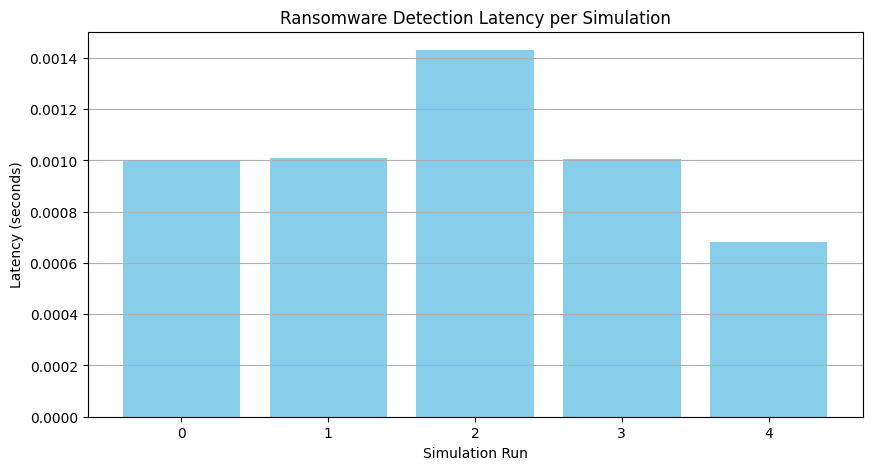

In [4]:
measured_latencies = []

def simulate_and_measure_latency(target_dir, num_simulations=5, interval_between_sims=5, files_per_sim=10):
    global detector_running
    if not detector_running:
        print("❌ Detector is not running. Please start it before measuring latency.")
        return

    print(f"Starting {num_simulations} ransomware simulation(s) in {target_dir}...")
    target_path = Path(target_dir)
    target_path.mkdir(parents=True, exist_ok=True) # Ensure directory exists

    for i in range(num_simulations):
        print(f"\n--- Simulation {i+1}/{num_simulations} ---")
        # Clear previous alerts/detections to avoid confusion
        detector.alerts.clear()
        detector.detection_history.clear()

        # --- IMPORTANT: Record event_start_time BEFORE simulating activity ---
        event_start_time = time.time()

        # --- ENHANCED RANSOMWARE SIMULATION ---
        # Simulate creating multiple suspicious files rapidly
        created_files = []
        print(f"  Simulating creation of {files_per_sim} suspicious files...")
        for _ in range(files_per_sim):
            suspicious_extension = random.choice(list(Config.SUSPICIOUS_EXTENSIONS))
            filename = f"latency_test_file_{datetime.now().strftime('%H%M%S%f')}_{random.randint(1000, 9999)}{suspicious_extension}"
            file_path = target_path / filename
            with open(file_path, 'w') as f:
                f.write(f"Ransomware test content {random.random()}")
            created_files.append(file_path)
            time.sleep(random.uniform(0.01, 0.05)) # Very rapid creation
        
        # Also simulate some modifications to existing (or just created) files
        num_modifications = random.randint(3, files_per_sim // 2)
        if created_files and num_modifications > 0:
            print(f"  Simulating {num_modifications} modifications...")
            for _ in range(num_modifications):
                file_to_modify = random.choice(created_files)
                with open(file_to_modify, 'a') as f:
                    f.write(f"\nModified by ransomware simulation {random.random()}")
                time.sleep(random.uniform(0.01, 0.05)) # Rapid modification
        
        print(f"  Finished initial burst of {files_per_sim} file creations and {num_modifications} modifications.")
        
        # Give FileSystemMonitor and main detection loop time to process events
        # This delay should be at least MONITORING_INTERVAL + a buffer
        delay_for_event_propagation = Config.MONITORING_INTERVAL + 2 # e.g., 10 + 2 = 12 seconds
        print(f"  Waiting {delay_for_event_propagation}s for file system events to propagate to detector and for detection cycle...")
        time.sleep(delay_for_event_propagation) 

        # --- DEBUG: Manually trigger feature extraction and print features ---
        current_features = detector.feature_extractor.extract_features(detector.file_monitor, detector.process_monitor)
        print(f"  DEBUG: Extracted Features at detection polling start: {list(zip(detector.feature_extractor.feature_names, current_features))}")
        # --- END DEBUG ---

        detection_time = None
        timeout_seconds = Config.MONITORING_INTERVAL + 5 # Max time to wait for detection, based on detection interval
        polling_interval = 1 # seconds
        elapsed_time = 0

        while elapsed_time < timeout_seconds:
            # --- DEBUGGING OUTPUT (during polling) ---
            print(f"  Elapsed (polling phase): {elapsed_time:.1f}s | Alerts: {len(detector.alerts)} | Detections: {len(detector.detection_history)}")
            if detector.alerts:
                print(f"    Latest Alert: {detector.alerts[-1]['message']} (Severity: {detector.alerts[-1]['severity']}) (Details: {detector.alerts[-1]['details']})")
            if detector.detection_history:
                print(f"    Latest Detection: {detector.detection_history[-1]['prediction']} (Risk: {detector.detection_history[-1]['risk_score']:.2f}) (Features: {list(zip(detector.feature_extractor.feature_names, detector.detection_history[-1]['features']))[:3]}...)") # Truncate features for brevity
            # --- END DEBUGGING OUTPUT ---

            if detector.alerts or detector.detection_history:
                new_alert_found = False
                # Check for new alerts/detections related to this event
                for alert in list(detector.alerts):
                    if ("ransomware" in alert['message'].lower() or
                        "suspicious file extensions" in alert['message'].lower() or
                        alert['severity'] == 'high' or
                        any(str(f) in alert['details'] for f in created_files)): # More robust check for paths in details
                        detection_time = alert['timestamp'].timestamp()
                        new_alert_found = True
                        break
                if new_alert_found:
                    break
                
                # Check for detections as well, even if no explicit alert was generated (model prediction)
                for det in list(detector.detection_history):
                    if det['prediction'] == 'Ransomware' and det['risk_score'] > Config.HIGH_RISK_THRESHOLD:
                        detection_time = det['timestamp'].timestamp()
                        new_alert_found = True
                        break
                if new_alert_found:
                    break

            time.sleep(polling_interval)
            elapsed_time += polling_interval

        if detection_time:
            latency = detection_time - event_start_time
            measured_latencies.append(latency)
            print(f"✅ Detection occurred! Latency: {latency:.4f} seconds.")
        else:
            print(f"❌ Detection timed out after {timeout_seconds} seconds for simulated event.")
            measured_latencies.append(float('inf')) # Indicate a missed detection

        # Clean up the created files
        for f_path in created_files:
            if f_path.exists():
                os.remove(f_path)
        print(f"Cleaned up {len(created_files)} simulated files.")

        time.sleep(interval_between_sims) # Pause between simulations

# Run latency measurement
if Config.FILE_MONITOR_PATHS:
    target_monitor_path = Config.FILE_MONITOR_PATHS[0] # Use the first configured path
    simulate_and_measure_latency(target_monitor_path, num_simulations=5)
else:
    print("❌ No FILE_MONITOR_PATHS configured. Cannot simulate latency.")


# Display latency results
if measured_latencies and any(l != float('inf') for l in measured_latencies):
    valid_latencies = [l for l in measured_latencies if l != float('inf')]
    print("\n" + "=" * 50)
    print("⏱️ Detection Latency Results")
    print("=" * 50)
    print(f"Average Latency: {np.mean(valid_latencies):.4f} seconds")
    print(f"Min Latency: {np.min(valid_latencies):.4f} seconds")
    print(f"Max Latency: {np.max(valid_latencies):.4f} seconds")
    print(f"Number of successful detections: {len(valid_latencies)}/{len(measured_latencies)}")

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(valid_latencies)), valid_latencies, color='skyblue')
    plt.xlabel('Simulation Run')
    plt.ylabel('Latency (seconds)')
    plt.title('Ransomware Detection Latency per Simulation')
    plt.grid(axis='y')
    plt.show()
else:
    print("\nNo successful latency measurements to display.")



In [5]:
## Stop the Detector

stop_detector_thread()


Stopping RansomwareDetector...
RansomwareDetector stopped.
